In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import extended, cubature, unscented, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearing_data_pe import get_data, make_parameters, inverse_bearings


In [2]:
s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

r_true = 0.05
T = 50
_, true_states, ys = get_data(x0, dt, r_true, T, s1, s2)
Q, _, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


positions = inverse_bearings(ys, s1, s2)
states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0), 
                          jnp.zeros((T+1,3))], axis = 1)

initial_states =  MVNStandard(states,0.1*jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(states,jnp.sqrt(0.1)*jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))


In [3]:
#standard
@jax.jit
def get_ell_std_extended(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))  
    
    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               extended, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

def get_ell_std_cubature(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               cubature, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

def get_ell_std_unscented(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               unscented, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

def get_ell_std_gh(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               gauss_hermite, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_std_extended = jax.jit(jax.value_and_grad(get_ell_std_extended))
grad_ell_std_cubature= jax.jit(jax.value_and_grad(get_ell_std_cubature))
grad_ell_std_unscented = jax.jit(jax.value_and_grad(get_ell_std_unscented))
grad_ell_std_gh = jax.jit(jax.value_and_grad(get_ell_std_gh))

In [4]:
gpu_grad_ell_std_extended = jax.jit(grad_ell_std_extended, backend="gpu")
gpu_grad_ell_std_cubature = jax.jit(grad_ell_std_cubature, backend="gpu")
gpu_grad_ell_std_unscented = jax.jit(grad_ell_std_unscented, backend="gpu")
gpu_grad_ell_std_gh = jax.jit(grad_ell_std_gh, backend="gpu")


In [5]:
def wrap_func_std_extended(r):
    loss, grad_val = gpu_grad_ell_std_extended(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)

def wrap_func_std_cubature(r):
    loss, grad_val = gpu_grad_ell_std_cubature(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)

def wrap_func_std_unscented(r):
    loss, grad_val = gpu_grad_ell_std_unscented(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)

def wrap_func_std_gh(r):
    loss, grad_val = gpu_grad_ell_std_gh(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)


In [6]:
r0 = np.array([10.])

r_cubature = 1 / minimize(wrap_func_std_cubature, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
r_unscented =  1 / minimize(wrap_func_std_unscented, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
r_gh = 1 / minimize(wrap_func_std_gh, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
r_extended = 1 / minimize(wrap_func_std_extended, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x


KeyboardInterrupt



In [ ]:
print("r_extended", r_extended)
print("r_cubature", r_cubature)
print("r_unscented", r_unscented)
print("r_gauss_hermite", r_gh)

In [ ]:
# log-likelihood plot
ell_extended =  np.array(jax.vmap(lambda r: get_ell_std_extended(r))(np.linspace(10, 50)[:, None]))
ell_cubature =  np.array(jax.vmap(lambda r: get_ell_std_cubature(r))(np.linspace(10, 50)[:, None]))
ell_unscented =  np.array(jax.vmap(lambda r: get_ell_std_unscented(r))(np.linspace(10, 50)[:, None]))
ell_gh =  np.array(jax.vmap(lambda r: get_ell_std_gh(r))(np.linspace(10, 50)[:, None]))


In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_extended),'r--')
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_cubature),'b')
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_unscented))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_gh),'*')
plt.grid()


In [ ]:
grad_ell_std_extended_T50_par = np.array(jax.vmap(lambda r: grad_ell_std_extended(r))(np.linspace(10, 50)[:, None])[1])
grad_ell_std_cubature_T50_par = np.array(jax.vmap(lambda r: grad_ell_std_cubature(r))(np.linspace(10, 50)[:, None])[1])
grad_ell_std_unscented_T50_par = np.array(jax.vmap(lambda r: grad_ell_std_unscented(r))(np.linspace(10, 50)[:, None])[1])
grad_ell_std_gh_T50_par = np.array(jax.vmap(lambda r: grad_ell_std_gh(r))(np.linspace(10, 50)[:, None])[1])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_extended_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_cubature_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_unscented_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_gh_T50_par))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.grid()



In [3]:
#square-root
@jax.jit
def get_ell_sqrt_extended(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))

    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                               extended, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

def get_ell_sqrt_cubature(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))

    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                               cubature, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

def get_ell_sqrt_unscented(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))

    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                               unscented, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

def get_ell_sqrt_gh(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))

    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, sqrt_observation_model,
                                               gauss_hermite, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_sqrt_extended = jax.jit(jax.value_and_grad(get_ell_sqrt_extended))
grad_ell_sqrt_cubature= jax.jit(jax.value_and_grad(get_ell_sqrt_cubature))
grad_ell_sqrt_unscented = jax.jit(jax.value_and_grad(get_ell_sqrt_unscented))
grad_ell_sqrt_gh = jax.jit(jax.value_and_grad(get_ell_sqrt_gh))

In [4]:
gpu_grad_ell_sqrt_extended = jax.jit(grad_ell_sqrt_extended, backend="gpu")
gpu_grad_ell_sqrt_cubature = jax.jit(grad_ell_sqrt_cubature, backend="gpu")
gpu_grad_ell_sqrt_unscented = jax.jit(grad_ell_sqrt_unscented, backend="gpu")
gpu_grad_ell_sqrt_gh = jax.jit(grad_ell_sqrt_gh, backend="gpu")

In [5]:
def wrap_func_sqrt_extended(r):
    loss, grad_val = gpu_grad_ell_sqrt_extended(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)

def wrap_func_sqrt_cubature(r):
    loss, grad_val = gpu_grad_ell_sqrt_cubature(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)

def wrap_func_sqrt_unscented(r):
    loss, grad_val = gpu_grad_ell_sqrt_unscented(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)

def wrap_func_sqrt_gh(r):
    loss, grad_val = gpu_grad_ell_sqrt_gh(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)


In [6]:
r0 = np.array([10.])
r_extended_sqrt = 1 / minimize(wrap_func_sqrt_extended, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
r_cubature_sqrt = 1 / minimize(wrap_func_sqrt_cubature, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
r_unscented_sqrt =  1 / minimize(wrap_func_sqrt_unscented, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x
r_gh_sqrt = 1 / minimize(wrap_func_sqrt_gh, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)]).x


In [7]:
print("r_extended", r_extended_sqrt)
print("r_cubature", r_cubature_sqrt)
print("r_unscented", r_unscented_sqrt)
print("r_gauss_hermite", r_gh_sqrt)

r_extended [0.04746554]


In [8]:
# log-likelihood plot
ell_extended_sqrt =  np.array(jax.vmap(lambda r: get_ell_sqrt_extended(r))(np.linspace(10, 50)[:, None]))
ell_cubature_sqrt =  np.array(jax.vmap(lambda r: get_ell_sqrt_cubature(r))(np.linspace(10, 50)[:, None]))
ell_unscented_sqrt =  np.array(jax.vmap(lambda r: get_ell_sqrt_unscented(r))(np.linspace(10, 50)[:, None]))
ell_gh_sqrt =  np.array(jax.vmap(lambda r: get_ell_sqrt_gh(r))(np.linspace(10, 50)[:, None]))

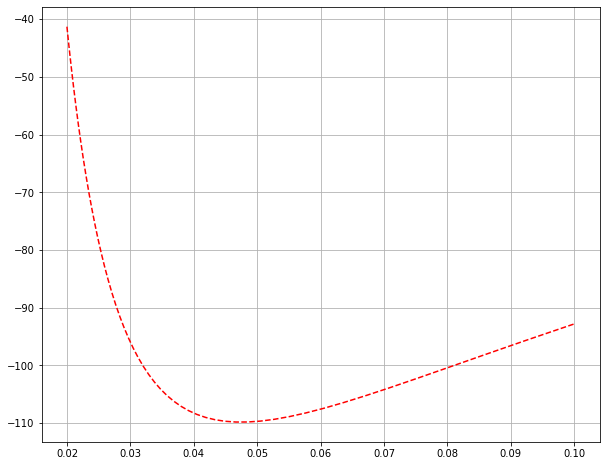

In [9]:
plt.figure(figsize=(10,8))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_extended_sqrt),'r--')
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_cubature_sqrt),'b')
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_unscented_sqrt))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_gh_sqrt),'*')
plt.grid()


In [14]:
grad_ell_sqrt_extended_T50_par = np.array(jax.vmap(lambda r: grad_ell_sqrt_extended(r))(np.linspace(10, 50)[:, None])[1])
grad_ell_sqrt_cubature_T50_par = np.array(jax.vmap(lambda r: grad_ell_sqrt_cubature(r))(np.linspace(10, 50)[:, None])[1])
grad_ell_sqrt_unscented_T50_par = np.array(jax.vmap(lambda r: grad_ell_sqrt_unscented(r))(np.linspace(10, 50)[:, None])[1])
grad_ell_sqrt_gh_T50_par = np.array(jax.vmap(lambda r: grad_ell_sqrt_gh(r))(np.linspace(10, 50)[:, None])[1])


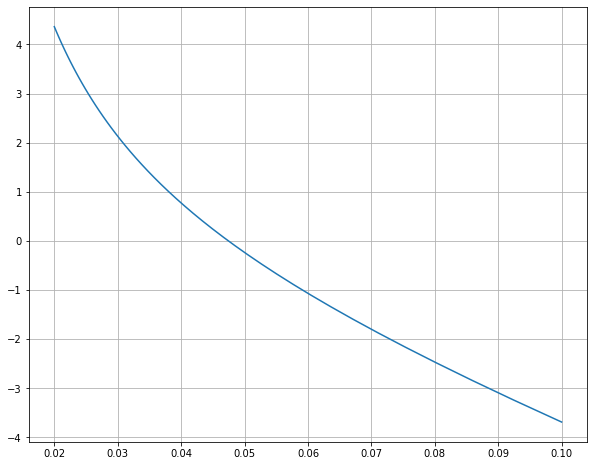

In [15]:
plt.figure(figsize=(10,8))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_extended_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_cubature_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_unscented_T50_par))
plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_gh_T50_par))
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.grid()


In [ ]:
# with np.load("pe_ell_std_extended_T50_par.npz") as loaded:
#     ell_std_extended_T50_par = loaded["ell_std_extended_T50_par"]
#     grad_ell_std_extended_T50_par = loaded["grad_ell_std_extended_T50_par"]
#     theta_par_std = loaded["theta_par_std"]
#
# with np.load("pe_ell_sqrt_extended_T50_par.npz") as loaded:
#     ell_sqrt_extended_T50_par = loaded["ell_sqrt_extended_T50_par"]
#     grad_ell_sqrt_extended_T50_par = loaded["grad_ell_sqrt_extended_T50_par"]
#     theta_par_sqrt = loaded["theta_par_sqrt"]



In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_std_extended_T50_par))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(ell_sqrt_extended_T50_par))
# plt.grid()
#
# print(theta_par_std)
# print(theta_par_sqrt)



In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_std_extended_T50_par))
# plt.plot(np.flip(1/np.linspace(10, 50)),np.flip(grad_ell_sqrt_extended_T50_par))
# plt.axhline(y = 0, color = 'r', linestyle = '--')
# plt.grid()

In [ ]:
# data = np.stack([np.flip(1/np.linspace(10, 50)),
#                  np.flip(ell_std_extended_T50_par),
#                  np.flip(ell_sqrt_extended_T50_par),
#                  np.flip(grad_ell_std_extended_T50_par[:,0]),
#                  np.flip(grad_ell_sqrt_extended_T50_par)[:,0]],
#                  axis=1)
#
# columns = ["ell",
#            "ell_std_extended_par",
#            "ell_sqrt_extended_par",
#            "grad_ell_std_extended_par",
#            "grad_ell_sqrt_extended_par"]
#
# df = pd.DataFrame(data=data, columns=columns)
# df.to_csv("outputs/pe_extended_ell_par.csv")

In [ ]:
RunTime Comparison

In [ ]:
T = 5000
_, _, ys = get_data(x0, dt, r_true, T, s1, s2)
positions = inverse_bearings(ys, s1, s2)
states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0),
                          jnp.zeros((T+1,3))], axis = 1)

initial_states_rt =  MVNStandard(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt_rt = MVNSqrt(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

In [ ]:
#parallel
def func(method, lengths, prec_r, n_runs=100, n_iter=10, sqrt=False):
    res_mean = []
    res_median = []
    for k, j in enumerate(lengths):
        print(f"Iteration {k+1} out of {len(lengths)}", end="\r")
        observations_slice = ys[:j]

        if sqrt:
            init_linearizations_points_slice = initial_states_sqrt_rt.mean[:j+1]
            init_linearizations_chols_slice = initial_states_sqrt.chol[:j+1]
            init_linearizations_states = MVNSqrt(init_linearizations_points_slice, init_linearizations_chols_slice)
            args = observations_slice, init_linearizations_states, n_iter
        else:
            init_linearizations_points_slice = initial_states.mean[:j+1]
            init_linearizations_covs_slice = initial_states.cov[:j+1]
            init_linearizations_states = MVNStandard(init_linearizations_points_slice, init_linearizations_covs_slice)
            args = observations_slice, init_linearizations_states, n_iter

        s = method(*args)
        s.mean.block_until_ready()
        run_times = []
        for _ in range(n_runs):
            tic = time.time()
            s_states = method(*args)
            s_states.mean.block_until_ready()
            toc = time.time()
            run_times.append(toc - tic)
        res_mean.append(np.mean(run_times))
        res_median.append(np.median(run_times))
    print()
    return np.array(res_mean), np.array(res_median)

lengths_space = np.logspace(2, int(np.log2(T)), num=10, base=2, dtype=int)

In [22]:
lengths_space = np.logspace(2, int(np.log2(5000)), num=10, base=2, dtype=int)
lengths_space

array([   4,    8,   18,   40,   87,  188,  406,  877, 1896, 4096])